Installation of Required Directories.

In [ ]:
#Install Qkeras
!pip install Qkeras

#Import from other installed directories
from qkeras import *
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from keras.layers import *
from qkeras import *


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Installing the mini speech commands data set from Google APIs. This data set constains 1 second audio clips of 8 keywords.

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

Checking if all the keywords have been installed.

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'left' 'no' 'down' 'go' 'yes' 'right' 'stop']


Checking the total No. of Audio Samples and No. of samples per label.

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/c634a189_nohash_0.wav', shape=(), dtype=string)


Dividing the Training, Validation and Test Set.

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


Decoding 16 bit wav files to a float tensor.

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each audio file is its parent directory.

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

This method takes in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Some Audio Waveforms with their corresponding labels.

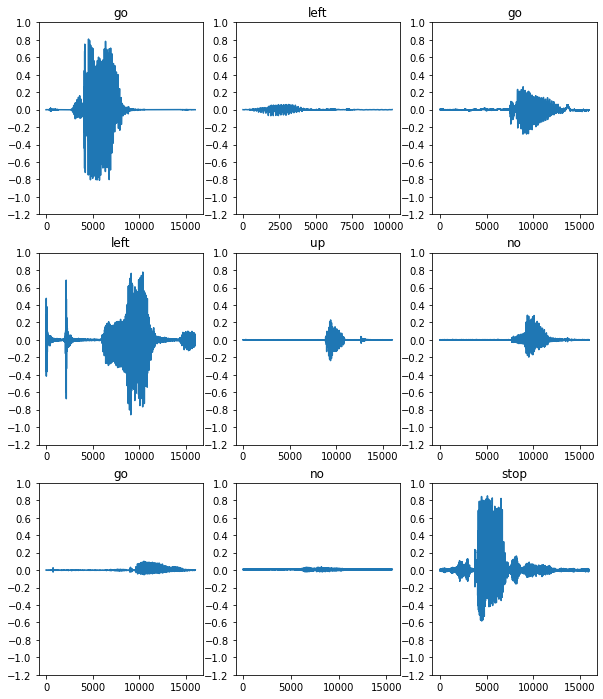

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

A spectrogram is created from the Audio files using Short Term Fourier Transform.

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Sample Audio with waveform shape and Spectrogram shape.

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Plot of a sample audio as a spectrogram

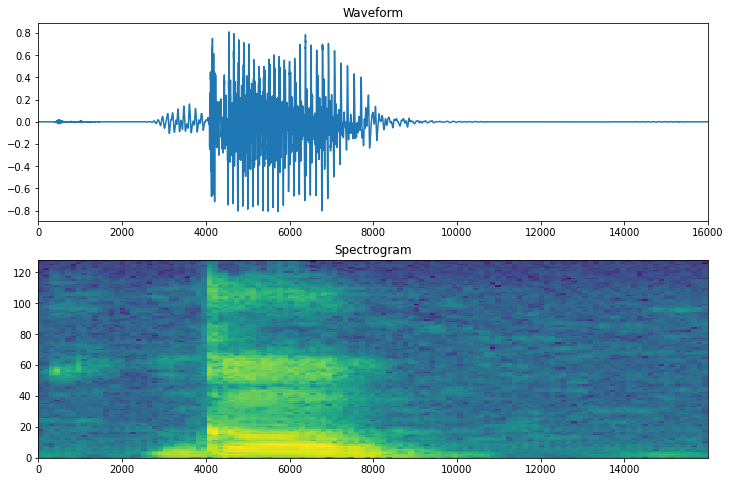

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examining some spectrogram images of the Audio Samples.

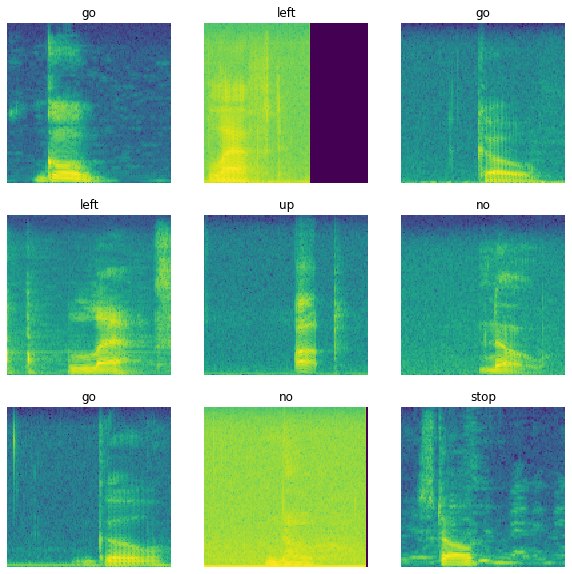

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

Preprocessing of Validation and Test Set.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and Validation sets for model training.

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Operations to reduce latency while reading the data.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)



Input shape: (124, 129, 1)


Defining the Network Architecture.

Batch Normalization is used to normalize the data as per its mean and standard deviation.

Resizing is used to reduce the training time.

QConv2D, QDense, QActivation layers(from Qkeras Library) are used to obtain Quantized weights during training.

In [ ]:
x = x_in = Input(input_shape)
#x= preprocessing.Resizing(32, 32)
#x = norm_layer.compute_output_shape(x)
x= tf.keras.layers.Resizing(32, 32)(x)
x=QBatchNormalization()(x)
x = QConv2D(32, 3,
        kernel_quantizer="stochastic_ternary",
        bias_quantizer="ternary", name="first_conv2d")(x)
x = QActivation("quantized_relu(3)")(x)
x = QConv2D(64, 3,
        kernel_quantizer="stochastic_ternary",
        bias_quantizer="ternary", name="second_conv2d")(x)
x = QActivation("quantized_relu(3)")(x)
x = MaxPooling2D()(x)
x = Dropout(0.35)(x)
x = Flatten()(x)
x = QDense(128,kernel_quantizer=quantized_bits(3),bias_quantizer=quantized_bits(3))(x)
x = QActivation("quantized_relu(3)")(x)
x = Dropout(0.35)(x)
x = QDense(num_labels,kernel_quantizer=quantized_bits(3),bias_quantizer=quantized_bits(3))(x)
#x = QActivation("quantized_relu(3)")(x)
#x = Activation("softmax")
#x = layer(x)
x = QActivation("quantized_bits(20, 5)")(x)
x = Activation("softmax")(x)
model = Model(inputs=x_in, outputs=x)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 124, 129, 1)]     0         
_________________________________________________________________
resizing_3 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
q_batch_normalization_3 (QBa (None, 32, 32, 1)         4         
_________________________________________________________________
first_conv2d (QConv2D)       (None, 30, 30, 32)        320       
_________________________________________________________________
q_activation_12 (QActivation (None, 30, 30, 32)        0         
_________________________________________________________________
second_conv2d (QConv2D)      (None, 28, 28, 64)        18496     
_________________________________________________________________
q_activation_13 (QActivation (None, 28, 28, 64)        0   

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00075),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


100/100 [==============================] - 51s 482ms/step - loss: 1.9598 - accuracy: 0.2483 - val_loss: 1.6589 - val_accuracy: 0.4175
Epoch 2/10
100/100 [==============================] - 32s 319ms/step - loss: 1.4541 - accuracy: 0.4791 - val_loss: 1.2228 - val_accuracy: 0.6112
Epoch 3/10
100/100 [==============================] - 32s 319ms/step - loss: 1.1275 - accuracy: 0.6187 - val_loss: 1.0189 - val_accuracy: 0.6612
Epoch 4/10
100/100 [==============================] - 32s 319ms/step - loss: 0.9023 - accuracy: 0.7063 - val_loss: 0.8132 - val_accuracy: 0.7337
Epoch 5/10
100/100 [==============================] - 32s 318ms/step - loss: 0.7433 - accuracy: 0.7614 - val_loss: 0.7480 - val_accuracy: 0.7513
Epoch 6/10
100/100 [==============================] - 32s 317ms/step - loss: 0.6587 - accuracy: 0.7892 - val_loss: 0.6782 - val_accuracy: 0.7675
Epoch 7/10
100/100 [==============================] - 32s 318ms/step - loss: 0.5581 - accuracy: 0.8213 - val_loss: 0.6302 - val_accuracy: 0.7

Training and Validation loss curves can be observed here.

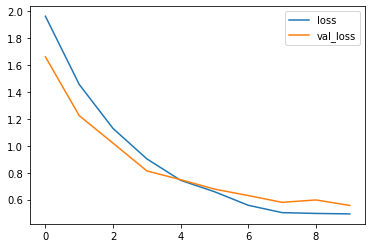

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

Running the model on the Test Set to check the performance.

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


Plotting the Confusion Matrix to see the models performance on each of the commands on the test set.

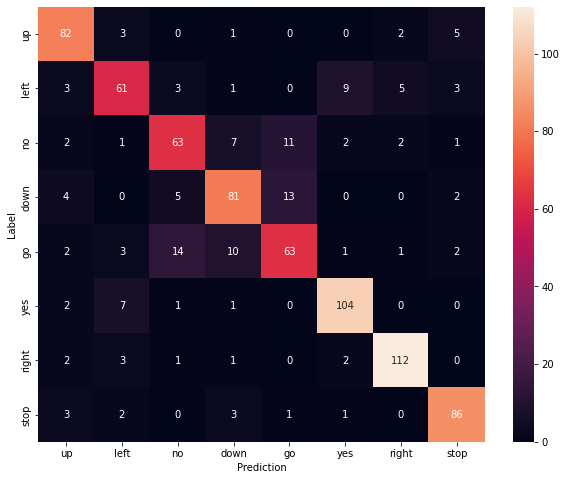

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()